## I - Problem Statement: The Housing Affordability Crisis in California

### 1 - The Broader Context: The U.S. Housing Crisis

Housing affordability has become one of the most pressing socio-economic challenges in the United States. Over the last decade, home prices and rent costs have surged far outpacing income growth. The COVID-19 pandemic, inflationary pressures, and shifts in remote work culture have further exacerbated disparities in housing accessibility. Many Americans, particularly those in metropolitan areas, struggle to secure stable housing as home prices continue to rise.

### 2 - Narrowing the Focus: California’s Housing Market & the Risk of Homelessness
California stands at the epicenter of this crisis. With some of the highest home prices and rent levels in the country, it has also experienced a significant rise in homelessness. Major metropolitan areas such as Los Angeles, San Francisco, San Diego, and San Jose have seen housing shortages, increasing eviction rates, and a growing population unable to afford rent or homeownership.
  
Limited housing supply and strict zoning laws.
The impact of economic fluctuations, including tech layoffs and inflation.
The lingering effects of the pandemic on household income.
The role of climate events (e.g., wildfires, droughts) in destabilizing local economies.
Given the severity of this crisis, understanding housing price trends in California’s largest cities is critical to predicting future affordability and assessing the potential risk of rising homelessness.

### 3 - Several factors contribute to this trend, including:

Using Zillow data, our project aims to analyze historical and recent housing price trends in California’s four largest cities. The key objective is to assess whether housing prices are becoming increasingly unaffordable, and if so, what that means for potential homelessness trends in these urban centers.

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np 
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## II - Data Wrangling

### 1 - Data Loading and description

In [6]:
# Load the dataset
file_path = "Metro_zhvi_uc_condo_tier_0.33_0.67_sm_sa_month.csv"   
df = pd.read_csv(file_path)
 
# Display basic info and first few rows
df.info()
df.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Columns: 305 entries, RegionID to 2024-12-31
dtypes: float64(300), int64(2), object(3)
memory usage: 1.2+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,102001,0,United States,country,NaN,115325.915427,115592.060520,115926.383663,116639.204020,117463.979899,...,342282.858301,343264.184973,343764.669429,343267.859665,342627.536193,342343.612264,342376.222334,342419.012312,342112.515368,341996.709733
1,394913,1,"New York, NY",msa,NY,189320.810824,190134.103344,190941.036047,192621.685727,194446.795433,...,520221.737052,523921.719261,527257.134511,529187.856043,531524.585383,534546.388891,537172.817987,539003.031204,540983.116763,543648.302506
2,753899,2,"Los Angeles, CA",msa,CA,168876.192248,169546.928649,170404.268819,172145.922690,174047.613011,...,665073.932563,666030.153452,668234.345051,668861.627222,670447.854688,672343.196875,675151.036088,676918.164181,678479.046259,679856.540075
3,394463,3,"Chicago, IL",msa,IL,127153.690396,127283.114698,127563.369101,128214.476443,129042.267870,...,233579.799941,235465.133734,236502.017115,236858.518543,237039.721001,237678.189388,238275.550364,238772.634309,238958.311575,239494.061418
4,394514,4,"Dallas, TX",msa,TX,85397.430477,85431.647377,85356.308969,85296.400353,85377.007895,...,237506.204627,238217.378615,237964.531157,236867.877212,235140.066362,233544.805575,232241.629484,231312.038815,230010.984637,228537.741981


### 2 - Data Reshaping

In [111]:
# Identify Columns
non_date_columns = ["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"]

# Identify actual date columns (all columns except metadata)
date_columns = [col for col in df.columns if col not in non_date_columns]

# Reshape the Dataset for Time-Series Analysis
df_melted = df.melt(id_vars=non_date_columns, var_name="Date", value_name="HomePrice")

# Convert Date column to datetime format
df_melted["Date"] = pd.to_datetime(df_melted["Date"], errors='coerce') 

### 3 - Data Cleaning


In [10]:
# Check for Missing Dates
if df_melted["Date"].isnull().sum() > 0:
    print(f"Warning: There are {df_melted['Date'].isnull().sum()} missing dates in the dataset.")
    df_melted = df_melted.dropna(subset=["Date"])  # Drop missing date values
else:
    print("✅ No missing dates found in the dataset.")

# Step 5: Check for Data Types
expected_types = {
    "RegionID": "int64",
    "SizeRank": "int64",
    "RegionName": "object",
    "RegionType": "object",
    "StateName": "object",
    "Date": "datetime64[ns]",
    "HomePrice": "float64"
}

# Identify incorrect data types
incorrect_types = {
    col: df_melted[col].dtype for col in expected_types.keys() if df_melted[col].dtype != expected_types[col]
}

if incorrect_types:
    print("⚠️ Warning: The following columns have incorrect data types:")
    for col, dtype in incorrect_types.items():
        print(f"   - {col}: Expected {expected_types[col]}, Found {dtype}")
else:
    print("✅ All columns have the correct data types.") 

✅ No missing dates found in the dataset.
✅ All columns have the correct data types.


### 4 - Detecting and visualizing and Removing Outliers 

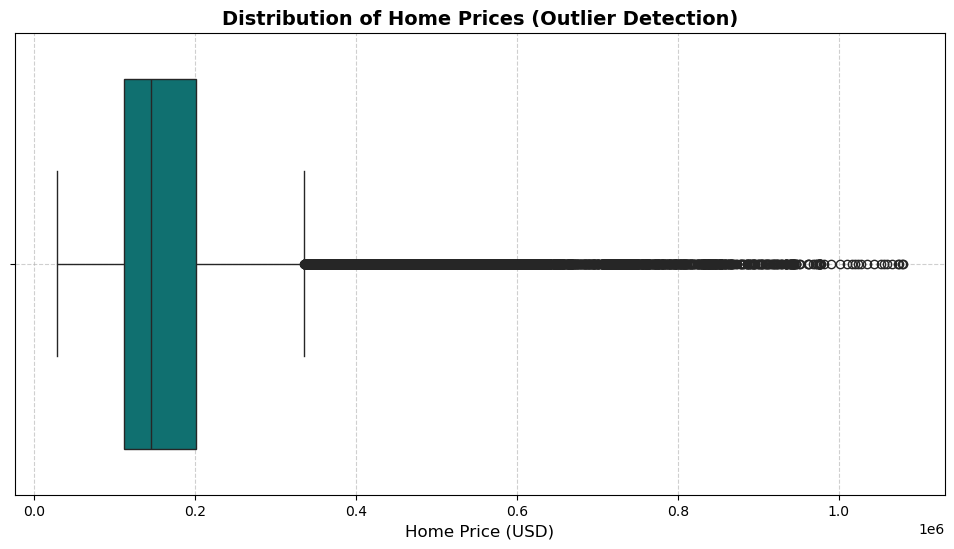

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,HomePrice
0,102001,0,United States,country,NaN,2000-01-31,115325.915427
1,394913,1,"New York, NY",msa,NY,2000-01-31,189320.810824
2,753899,2,"Los Angeles, CA",msa,CA,2000-01-31,168876.192248
3,394463,3,"Chicago, IL",msa,IL,2000-01-31,127153.690396
4,394514,4,"Dallas, TX",msa,TX,2000-01-31,85397.430477


In [19]:
# Detect and Visualize Outliers with a Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_melted["HomePrice"], color="teal")

plt.title("Distribution of Home Prices (Outlier Detection)", fontsize=14, fontweight="bold")
plt.xlabel("Home Price (USD)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Compute the Interquartile Range (IQR)
Q1 = df_melted["HomePrice"].quantile(0.25)
Q3 = df_melted["HomePrice"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_no_outliers = df_melted[(df_melted["HomePrice"] >= lower_bound) & (df_melted["HomePrice"] <= upper_bound)]

# Display the new dataset without outliers
df_no_outliers.head()


#
comment

### 5 - What is the average Home Price per City Over Time?

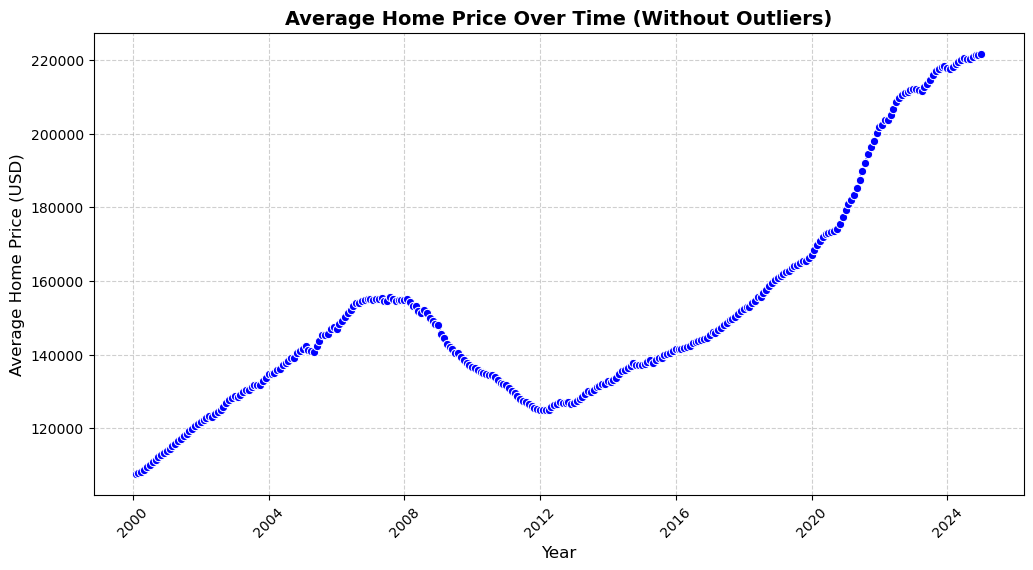

In [21]:
# Compute average home price over time (without outliers)
df_avg_price_over_time_no_outliers = df_no_outliers.groupby("Date")["HomePrice"].mean().reset_index()

# Plot the time-series trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_price_over_time_no_outliers, x="Date", y="HomePrice", marker="o", linestyle="-", color="b")

# Customize the plot
plt.title("Average Home Price Over Time (Without Outliers)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Home Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show() 

 ###  6 - Segmenting the data for Carlifornia

In [81]:
# Segment Data for California Cities and Extract City Names
df_melted["City"] = df_melted["RegionName"].apply(lambda x: x.split(",")[0])
selected_cities = ["Los Angeles", "San Francisco", "San Diego", "San Jose"]
df_california = df_melted[df_melted["City"].isin(selected_cities)]

# Keep only selected cities
selected_cities = ["Los Angeles", "San Francisco", "San Diego", "San Jose"]
df_city_level = df_california[df_california["City"].isin(selected_cities)]

# Display the filtered dataset
from IPython.display import display
print("✅ Filtered dataset at the city level:")
display(df_city_level.head())

# Aggregate average home prices per city over time
df_city_avg = df_city_level.groupby(["City", "Date"])["HomePrice"].mean().reset_index()

# Display results
print("✅ Aggregated home prices per city over time:")
display(df_city_avg.head())   

✅ Filtered dataset at the city level:


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,HomePrice,City
2,753899,2,"Los Angeles, CA",msa,CA,2000-01-31,168876.192248,Los Angeles
12,395057,12,"San Francisco, CA",msa,CA,2000-01-31,229860.254087,San Francisco
17,395056,17,"San Diego, CA",msa,CA,2000-01-31,148359.807547,San Diego
35,395059,36,"San Jose, CA",msa,CA,2000-01-31,242056.719175,San Jose
523,753899,2,"Los Angeles, CA",msa,CA,2000-02-29,169546.928649,Los Angeles


✅ Aggregated home prices per city over time:


,City,Date,HomePrice
0,Los Angeles,2000-01-31,168876.192248
1,Los Angeles,2000-02-29,169546.928649
2,Los Angeles,2000-03-31,170404.268819
3,Los Angeles,2000-04-30,172145.922690
4,Los Angeles,2000-05-31,174047.613011


In [85]:
# Keep only selected cities
selected_cities = ["Los Angeles", "San Francisco", "San Diego", "San Jose"]
df_city_level = df_california[df_california["City"].isin(selected_cities)]

# Display the filtered dataset
from IPython.display import display
print("✅ Filtered dataset at the city level:")
display(df_city_level.head())

# Aggregate average home prices per city over time
df_city_avg = df_city_level.groupby(["City", "Date"])["HomePrice"].mean().reset_index()

# Display results
print("✅ Aggregated home prices per city over time:")
display(df_city_avg.head())   

# Compute summary statistics for each city
city_overview = df_city_level.groupby("City").agg(
    Total_Records=("HomePrice", "count"),
    First_Date=("Date", "min"),
    Last_Date=("Date", "max"),
    Avg_HomePrice=("HomePrice", "mean"),
    Min_HomePrice=("HomePrice", "min"),
    Max_HomePrice=("HomePrice", "max")
).reset_index()

# Display the overview in a well-structured format
from IPython.display import display
print("✅ Overview of Housing Data for Selected Cities:")
display(city_overview)


✅ Filtered dataset at the city level:


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,HomePrice,City
2,753899,2,"Los Angeles, CA",msa,CA,2000-01-31,168876.192248,Los Angeles
12,395057,12,"San Francisco, CA",msa,CA,2000-01-31,229860.254087,San Francisco
17,395056,17,"San Diego, CA",msa,CA,2000-01-31,148359.807547,San Diego
35,395059,36,"San Jose, CA",msa,CA,2000-01-31,242056.719175,San Jose
523,753899,2,"Los Angeles, CA",msa,CA,2000-02-29,169546.928649,Los Angeles


✅ Aggregated home prices per city over time:


,City,Date,HomePrice
0,Los Angeles,2000-01-31,168876.192248
1,Los Angeles,2000-02-29,169546.928649
2,Los Angeles,2000-03-31,170404.268819
3,Los Angeles,2000-04-30,172145.922690
4,Los Angeles,2000-05-31,174047.613011


✅ Overview of Housing Data for Selected Cities:


,City,Total_Records,First_Date,Last_Date,Avg_HomePrice,Min_HomePrice,Max_HomePrice
0,Los Angeles,300,2000-01-31,2024-12-31,398312.755020,168876.192248,679856.540075
1,San Diego,300,2000-01-31,2024-12-31,354856.828795,148359.807547,657199.396145
2,San Francisco,299,2000-01-31,2024-12-31,512372.699834,229860.254087,817446.429007
3,San Jose,299,2000-01-31,2024-12-31,505299.029016,242056.719175,853121.459191


In [ ]:
# Step 7: Compute the 3-Year Percentage Change in Home Prices
latest_date = df_melted["Date"].max()
three_years_ago = latest_date - pd.DateOffset(years=3)

df_latest_prices = df_melted[df_melted["Date"] == latest_date].groupby("StateName")["HomePrice"].mean().reset_index()
df_old_prices = df_melted[df_melted["Date"] == three_years_ago].groupby("StateName")["HomePrice"].mean().reset_index()

df_price_change = df_old_prices.merge(df_latest_prices, on="StateName", suffixes=("_old", "_new"))
df_price_change["Percentage Change"] = ((df_price_change["HomePrice_new"] - df_price_change["HomePrice_old"]) / df_price_change["HomePrice_old"]) * 100

df_price_change = df_price_change.sort_values(by="Percentage Change", ascending=False)

# Step 8: Create a Professional & Informative Bar Chart for 3-Year Percentage Change
plt.figure(figsize=(14, 7))
sns.barplot(x=df_price_change["Percentage Change"], y=df_price_change["StateName"], palette="coolwarm", edgecolor="black")

for index, row in df_price_change.iterrows():
    plt.text(row["Percentage Change"] + 1, index, f"{row['Percentage Change']:.1f}%", ha="left", va="center", fontsize=10)

plt.title(f"3-Year Change in Home Prices by State @ {latest_date.strftime('%B %Y')}", fontsize=14, fontweight="bold")
plt.xlabel("Percentage Change in Home Prices", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.axvline(x=0, color='black', linewidth=1)
plt.show()

## III - Data Analysis: 

### How have housing costs evolved over time in California's major cities—Los Angeles, San Francisco, San Diego, and San Jose—and what are the projected home price trends for these cities over the next 5-10 years?

### Los Angeles  

### How have housing prices changed over the past decade in these four California cities? 

C:\Users\Graduate\AppData\Local\Temp\ipykernel_3840\965755352.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_cities["Year"] = df_selected_cities["Date"].dt.year


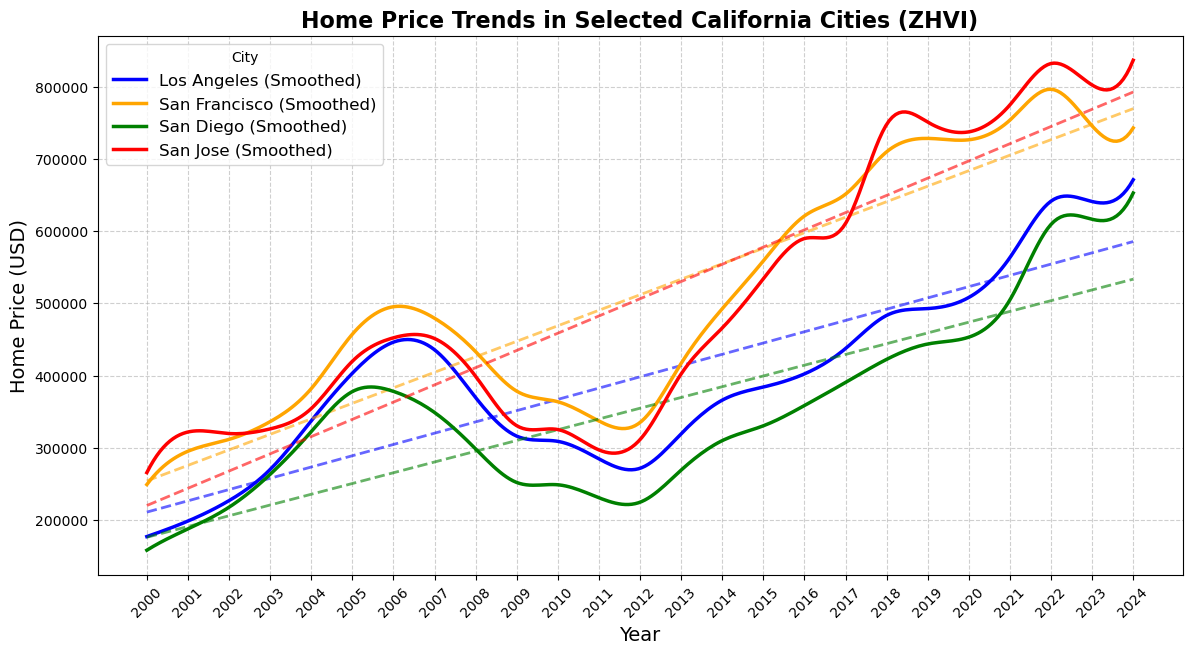

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import CubicSpline

# Ensure df_selected_cities is correctly filtered
df_selected_cities["Year"] = df_selected_cities["Date"].dt.year

# Prepare figure
plt.figure(figsize=(14, 7))

# Define colors for cities
city_colors = {
    "Los Angeles": "blue",
    "San Francisco": "orange",
    "San Diego": "green",
    "San Jose": "red"
}

# Smooth data and plot
for city in df_selected_cities["City"].unique():
    city_data = df_selected_cities[df_selected_cities["City"] == city]
    
    # Aggregate yearly averages
    city_avg = city_data.groupby("Year")["HomePrice"].mean().reset_index()
    
    # Interpolation for smoothing
    X = city_avg["Year"]
    Y = city_avg["HomePrice"]
    
    # Generate smooth X values
    X_smooth = np.linspace(X.min(), X.max(), 300)
    
    # Apply Cubic Spline
    cs = CubicSpline(X, Y)
    Y_smooth = cs(X_smooth)

    # Plot smooth line
    plt.plot(X_smooth, Y_smooth, label=f"{city} (Smoothed)", color=city_colors[city], linewidth=2.5)
    
    # Plot trend line (linear regression)
    z = np.polyfit(X, Y, 1)  # Linear fit (degree 1 polynomial)
    trend = np.poly1d(z)
    plt.plot(X, trend(X), linestyle="dashed", color=city_colors[city], alpha=0.6, linewidth=2)

# Format the chart
plt.title("Home Price Trends in Selected California Cities (ZHVI)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Home Price (USD)", fontsize=14)
plt.xticks(np.arange(df_selected_cities["Year"].min(), df_selected_cities["Year"].max() + 1, step=1), rotation=45)
plt.legend(title="City", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the chart
plt.show()



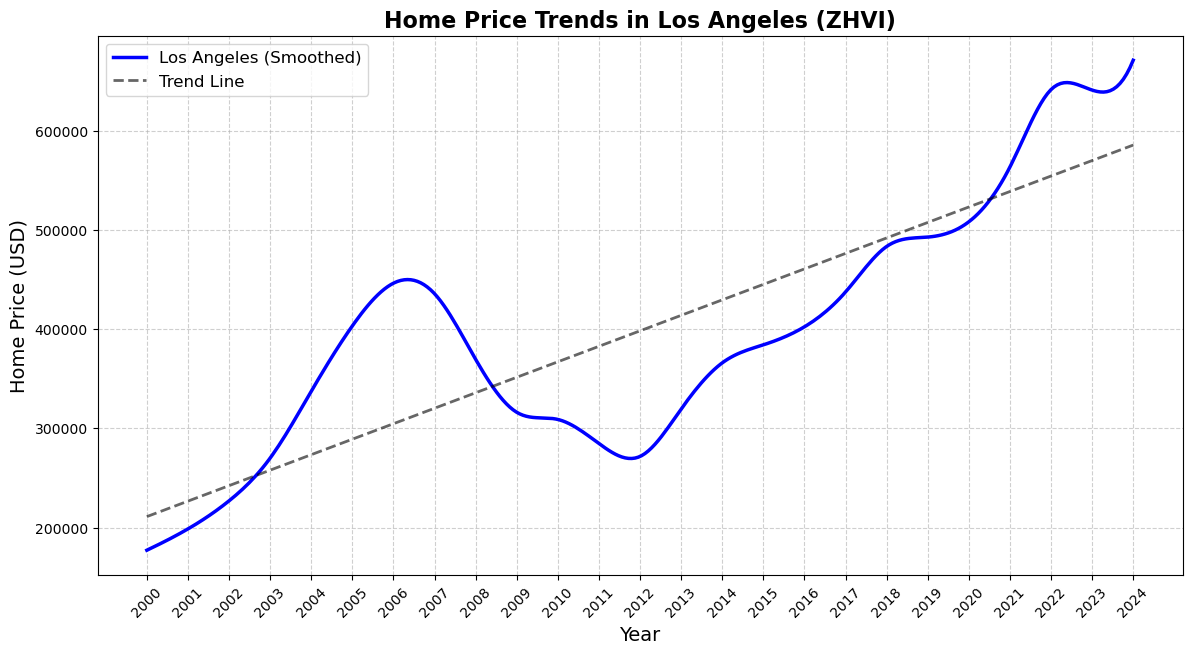

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Filter for Los Angeles only
df_LA = df_selected_cities[df_selected_cities["City"] == "Los Angeles"].copy()

# Aggregate yearly averages
df_LA["Year"] = df_LA["Date"].dt.year
df_LA_avg = df_LA.groupby("Year")["HomePrice"].mean().reset_index()

# Interpolation for smoothing
X = df_LA_avg["Year"]
Y = df_LA_avg["HomePrice"]

# Generate smooth X values
X_smooth = np.linspace(X.min(), X.max(), 300)

# Apply Cubic Spline
cs = CubicSpline(X, Y)
Y_smooth = cs(X_smooth)

# Plot smooth line
plt.figure(figsize=(14, 7))
plt.plot(X_smooth, Y_smooth, label="Los Angeles (Smoothed)", color="blue", linewidth=2.5)

# Plot trend line (linear regression)
z = np.polyfit(X, Y, 1)  # Linear fit (degree 1 polynomial)
trend = np.poly1d(z)
plt.plot(X, trend(X), linestyle="dashed", color="black", alpha=0.6, linewidth=2, label="Trend Line")

# Format the chart
plt.title("Home Price Trends in Los Angeles (ZHVI)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Home Price (USD)", fontsize=14)
plt.xticks(np.arange(df_LA["Year"].min(), df_LA["Year"].max() + 1, step=1), rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the chart
plt.show() 

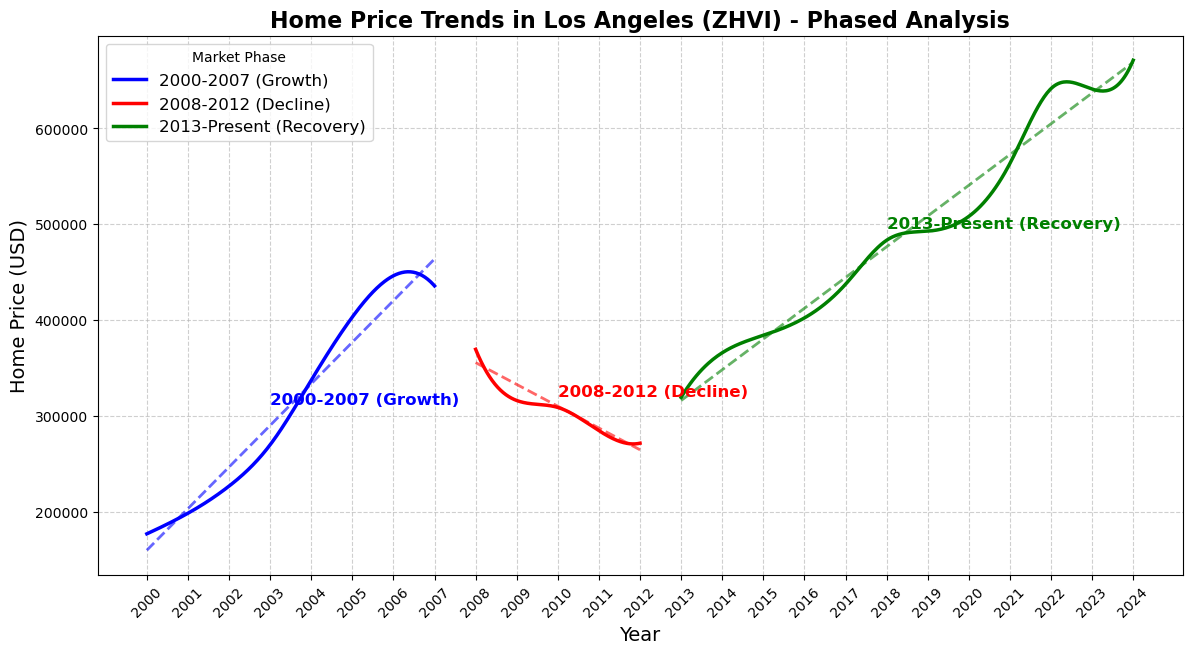

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Aggregate yearly averages for Los Angeles
df_LA["Year"] = df_LA["Date"].dt.year
df_LA_avg = df_LA.groupby("Year")["HomePrice"].mean().reset_index()

# Identify key phases in price movement
phases = {
    "2000-2007 (Growth)": df_LA_avg[(df_LA_avg["Year"] >= 2000) & (df_LA_avg["Year"] <= 2007)],
    "2008-2012 (Decline)": df_LA_avg[(df_LA_avg["Year"] >= 2008) & (df_LA_avg["Year"] <= 2012)],
    "2013-Present (Recovery)": df_LA_avg[(df_LA_avg["Year"] >= 2013)]
}

# Define colors for each phase
phase_colors = {
    "2000-2007 (Growth)": "blue",
    "2008-2012 (Decline)": "red",
    "2013-Present (Recovery)": "green"
}

plt.figure(figsize=(14, 7))

# Plot each phase with smoothing and trend line
for phase_name, phase_data in phases.items():
    X = phase_data["Year"]
    Y = phase_data["HomePrice"]
    
    # Generate smooth X values
    X_smooth = np.linspace(X.min(), X.max(), 300)
    
    # Apply Cubic Spline
    cs = CubicSpline(X, Y)
    Y_smooth = cs(X_smooth)

    # Plot smooth line for the phase
    plt.plot(X_smooth, Y_smooth, color=phase_colors[phase_name], linewidth=2.5, label=f"{phase_name}")

    # Trend line for the phase
    z = np.polyfit(X, Y, 1)  # Linear fit (degree 1 polynomial)
    trend = np.poly1d(z)
    plt.plot(X, trend(X), linestyle="dashed", color=phase_colors[phase_name], alpha=0.6, linewidth=2)

    # Annotate phase period
    mid_year = int((X.min() + X.max()) / 2)
    mid_price = (Y.max() + Y.min()) / 2
    plt.text(mid_year, mid_price, f"{phase_name}", fontsize=12, color=phase_colors[phase_name], fontweight="bold")

# Chart formatting
plt.title("Home Price Trends in Los Angeles (ZHVI) - Phased Analysis", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Home Price (USD)", fontsize=14)
plt.xticks(np.arange(df_LA["Year"].min(), df_LA["Year"].max() + 1, step=1), rotation=45)
plt.legend(title="Market Phase", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


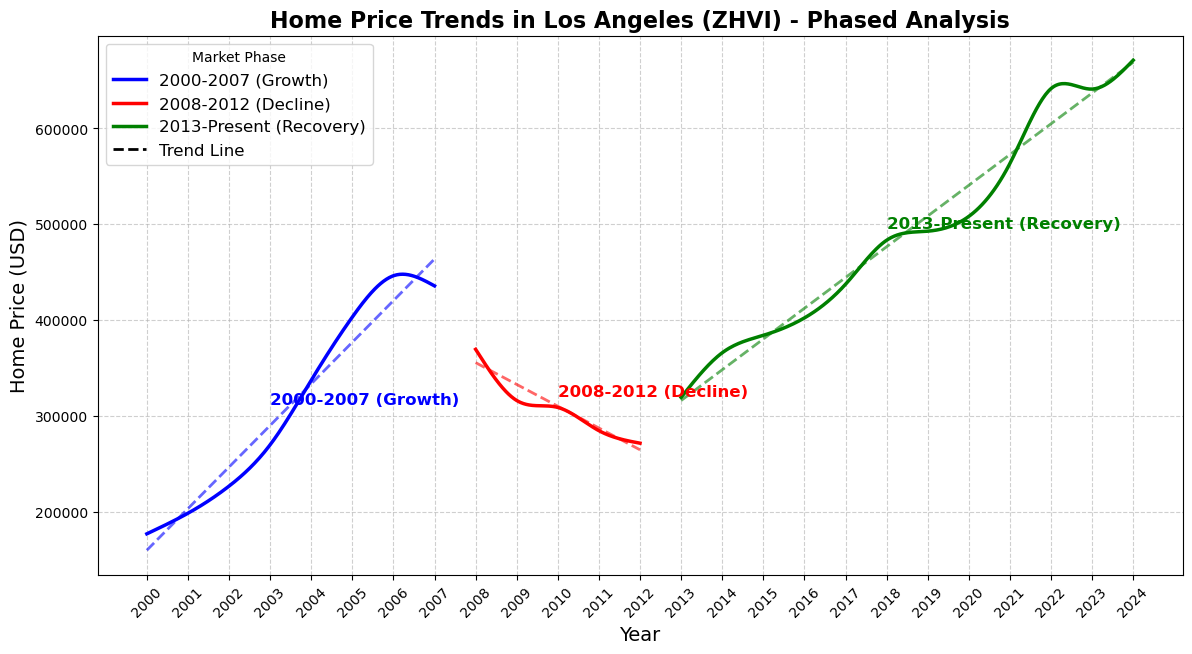

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from matplotlib.lines import Line2D

# Aggregate yearly averages for Los Angeles
df_LA["Year"] = df_LA["Date"].dt.year
df_LA_avg = df_LA.groupby("Year")["HomePrice"].mean().reset_index()

# Identify key phases in price movement
phases = {
    "2000-2007 (Growth)": df_LA_avg[(df_LA_avg["Year"] >= 2000) & (df_LA_avg["Year"] <= 2007)],
    "2008-2012 (Decline)": df_LA_avg[(df_LA_avg["Year"] >= 2008) & (df_LA_avg["Year"] <= 2012)],
    "2013-Present (Recovery)": df_LA_avg[(df_LA_avg["Year"] >= 2013)]
}

# Define colors for each phase
phase_colors = {
    "2000-2007 (Growth)": "blue",
    "2008-2012 (Decline)": "red",
    "2013-Present (Recovery)": "green"
}

plt.figure(figsize=(14, 7))

# Improved legend storage
legend_handles = []

# Plot each phase with smoothing and trend line
for phase_name, phase_data in phases.items():
    X = phase_data["Year"]
    Y = phase_data["HomePrice"]

    # Generate smooth X values
    X_smooth = np.linspace(X.min(), X.max(), 300)
    
    # Apply Cubic Spline and ensure smooth connection
    if len(X) > 3:  # Avoid errors with too few data points
        cs = CubicSpline(X, Y, bc_type='natural')  # Natural boundary conditions
        Y_smooth = cs(X_smooth)

        # Plot smooth line for the phase
        line, = plt.plot(X_smooth, Y_smooth, color=phase_colors[phase_name], linewidth=2.5, label=f"{phase_name}")

        # Trend line for the phase
        z = np.polyfit(X, Y, 1)  # Linear fit (degree 1 polynomial)
        trend = np.poly1d(z)
        trend_line, = plt.plot(X, trend(X), linestyle="dashed", color=phase_colors[phase_name], alpha=0.6, linewidth=2)

        # Annotate phase period
        mid_year = int((X.min() + X.max()) / 2)
        mid_price = (Y.max() + Y.min()) / 2
        plt.text(mid_year, mid_price, f"{phase_name}", fontsize=12, color=phase_colors[phase_name], fontweight="bold")

        # Store handles for legend
        legend_handles.append((line, trend_line))

# Chart formatting
plt.title("Home Price Trends in Los Angeles (ZHVI) - Phased Analysis", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Home Price (USD)", fontsize=14)
plt.xticks(np.arange(df_LA["Year"].min(), df_LA["Year"].max() + 1, step=1), rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Create an improved legend
custom_legend = [Line2D([0], [0], color=phase_colors[name], lw=2.5, label=name) for name in phases.keys()]
custom_legend += [Line2D([0], [0], linestyle="dashed", color="black", lw=2, label="Trend Line")]

plt.legend(handles=custom_legend, title="Market Phase", fontsize=12, loc="upper left")

# Show the plot
plt.show() 

In [ ]:
# Step 6: Annual Growth Rate of Home Prices
df_selected_cities["Year"] = df_selected_cities["Date"].dt.year
df_yearly = df_selected_cities.groupby(["City", "Year"])["HomePrice"].mean().reset_index()
df_yearly["YoY_Growth"] = df_yearly.groupby("City")["HomePrice"].pct_change() * 100

In [ ]:
# Step 7: Home Price Volatility
df_selected_cities["Rolling_Volatility"] = df_selected_cities.groupby("City")["HomePrice"].rolling(window=12).std().reset_index(level=0, drop=True)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_selected_cities, x="Date", y="Rolling_Volatility", hue="City")
plt.title("Home Price Volatility Over Time in Selected Cities", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rolling Standard Deviation (Volatility)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Step 8: Housing Affordability Analysis (Price-to-Income Ratio)
median_income = {2000: 45000, 2010: 55000, 2020: 70000}  # Hypothetical median income
df_income = pd.DataFrame(median_income.items(), columns=["Year", "Median_Income"])
df_affordability = df_yearly.merge(df_income, on="Year", how="left")
df_affordability["Price_to_Income_Ratio"] = df_affordability["HomePrice"] / df_affordability["Median_Income"]


In [ ]:
# Step 9: Future Home Price Prediction (ARIMA Model) for Selected Cities
df_forecast_list = []
for city in selected_cities:
    df_city = df_yearly[df_yearly["City"] == city].copy()
    df_city["Date_Ordinal"] = pd.to_datetime(df_city["Year"], format="%Y").map(pd.Timestamp.toordinal)
    model = ARIMA(df_city["HomePrice"], order=(2,1,2))
    model_fit = model.fit()
    future_years = list(range(2024, 2030))
    future_ordinal = [pd.Timestamp(f"{year}-01-01").toordinal() for year in future_years]
    forecast = model_fit.forecast(steps=len(future_years))
    df_forecast = pd.DataFrame({"City": city, "Year": future_years, "Predicted_HomePrice": forecast})
    df_forecast_list.append(df_forecast)

df_forecast_final = pd.concat(df_forecast_list)

# Display results
from IPython.display import display
print("✅ Yearly Home Price Growth in Selected Cities:")
display(df_yearly.head())
print("✅ Housing Affordability Trends in Selected Cities:")
display(df_affordability.head())
print("✅ Future Home Price Predictions for Selected Cities:")
display(df_forecast_final)


Breaking Down the Business Question into Key Sub-Questions:
To systematically approach this problem, we will answer the following:

How have housing prices changed over the past decade in these four California cities?

Analyze trends in median home prices and rental prices.
Compare past price changes to wage growth and inflation.
Are there noticeable price spikes or downturns in specific years? What events correlate with these changes?

Identify economic shocks (e.g., the pandemic, recession, tech industry layoffs).
Assess if these events led to sudden increases in home prices or made housing more affordable.
Do current trends suggest future price increases or decreases?

Use predictive modeling (time-series forecasting) to estimate future housing costs.
Assess whether affordability is expected to improve or worsen.
How do these housing trends compare to homelessness statistics?

If available, incorporate data on homelessness rates per city and compare them to housing affordability.
Investigate whether rising prices correlate with higher eviction rates or homelessness.
What policy recommendations can be made to mitigate the impact of rising housing costs?

Suggest potential actions based on historical trends, affordability indices, and predictive models.
Next Steps
With these guiding questions, we will now begin collecting, cleaning, and analyzing Zillow’s housing data for our four chosen cities. The results will help us determine whether California’s housing market trends indicate a worsening homelessness crisis—and what actions can be taken to address it.

This structure ensures a clear research direction while making it easy to integrate findings as you progress in your Jupyter Notebook. 🚀

Would you like me to help with data extraction, visualization scripts, or forecasting models next? 

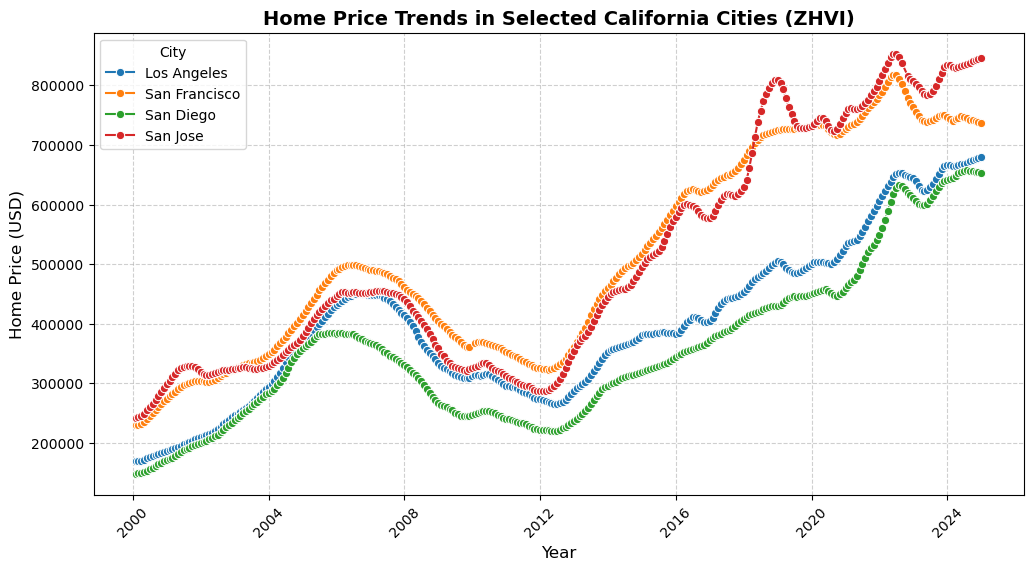

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df_selected_cities is defined
df_melted["City"] = df_melted["RegionName"].apply(lambda x: x.split(",")[0])
selected_cities = ["Los Angeles", "San Francisco", "San Diego", "San Jose"]
df_selected_cities = df_melted[df_melted["City"].isin(selected_cities)]

# Step 5: Home Price Trends Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_selected_cities, x="Date", y="HomePrice", hue="City", marker="o")

plt.title("Home Price Trends in Selected California Cities (ZHVI)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Home Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()